<a href="https://colab.research.google.com/github/Nadia-Moulouad/Forecasting-Scochastic-Model/blob/main/seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# seasonal data analysis

The data was found on kaggle : https://www.kaggle.com/datasets/sandeeptudu/indian-major-cities-daily-temperatures-1995-2019
The dataset contains daily temperature for four major cities in India : Kolkata , Mumbai , Chennai , Delhi. But we will only be interested in the first day of each month.
The dataset has been curated from : academic.udayton.edu.
We will be looking at 2 columns :

Date - The date of the observation


mumbai - the daily temperature in mumbai (in Farenheights)

In [8]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plots
from statsmodels.tsa.seasonal import seasonal_decompose, STL # to check for seasonality
from statsmodels.tsa.stattools import adfuller # augmented Dickey-Fuller test
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

# ploting the time series versus time

We are only plotting the time series for the city of mumbai, we are combining day month and year into a single column called 'date' and we will only display the first day of each month from 2004 to 2019.


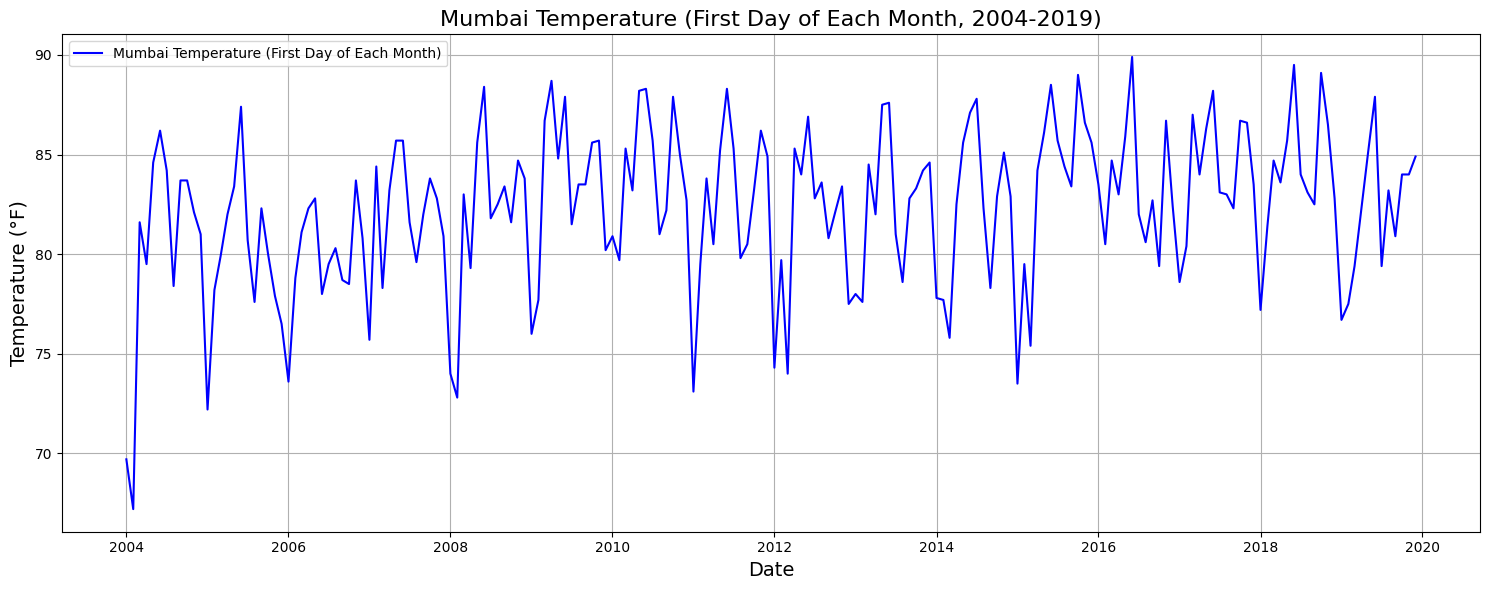

In [9]:

# load CSV file
file_path = "./Daily Temperatures 1995-2019 for Major Indian Cities.csv"
data = pd.read_csv(file_path)

# combine year, month, and day into a single 'date' column
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# only Mumbai temperature and drop rows with missing values
data = data[['date', 'mumbai']].dropna()

# Convert 'mumbai' column to float, coercing invalid values to NaN
data['mumbai'] = pd.to_numeric(data['mumbai'], errors='coerce')

# remove rows where there might have been a conversion error, still works without it though...
# data = data.dropna(subset=['mumbai'])

data_filtered = data[(data['date'] >= '2004-01-01') & (data['date'] <= '2019-12-31')]

#only the first day of each month
data_first_day = data_filtered[data_filtered['date'].dt.is_month_start]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(data_first_day['date'], data_first_day['mumbai'], label='Mumbai Temperature (First Day of Each Month)', color='blue')
plt.title('Mumbai Temperature (First Day of Each Month, 2004-2019)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature (°F)', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/Temperature_vs_time.png', dpi=300)



# checking for seasonality (using STL)

There seem to be a clear sesonal component in this time series, as indicated by the stl which helps us see it better by decomposing the time series into 3 parts : trend, seasonality and residual.

In [10]:
# period is the number of observations in the cycle
advanced_decomposition = STL(data_first_day.mumbai, period=12).fit()

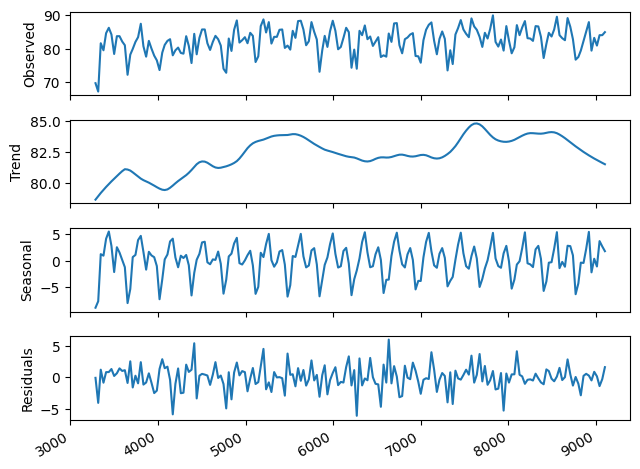

In [11]:
# decomposing the time series into Trend, Seasonality and residual
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/STL.png', dpi=300)



# Dickey-Fuller(ADF) test to see if the data is stationary or not

The ADF statistic is a negative number (-5.56), but the p-value is higher (0.28) than 0.05,which means we can't reject the null
hypothesis stating that our time series is not stationary (here, that means that the data has a trend and seasonality).


Therefore, the data for this time series might need to be transformed using a diferenciation.

In [12]:
# Perform the ADF test on the 'weekly sales' column of the 'dfstore' dataframe
ADF_result = adfuller(data_first_day['mumbai'])

# Print the ADF statistic obtained from the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

#Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.0096010542222276
p-value: 0.28237930337255446


In [13]:
mumbai_diff = np.diff(data_first_day['mumbai'], n=1)

We perform the ADF again on the diferenciated time series, we can observe that the p-value is now lower that 0.05 which means we can reject the null hypothesis. our data is stationary. the d parameter we need to use in the SARIMA model will be one).


In [14]:
# Perform the ADF test on the 'weekly sales' column of the 'dfstore' dataframe
ADF_result = adfuller(mumbai_diff)

# Print the ADF statistic obtained from the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

#Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.849280473547768
p-value: 7.27316371063305e-22


# Plotting the auto corellation function (ACF) to get an idea of which model to apply

We notice some spikes at certain lags: lag 1, 12, 24, 36, etc. which maches the number of month in a year, it shows that temperature data has a seasonal.
there are many spikes that fall outside the confidence interval, this indicates a statistically significant autocorrelation at those lags.

the autocorelation slowly becomes less significant as the lags increase.

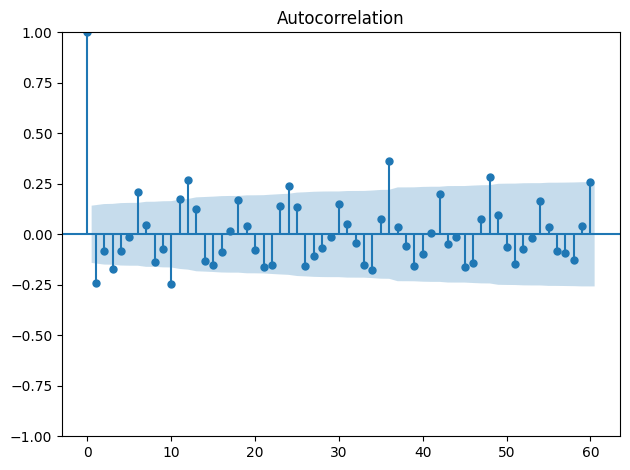

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(mumbai_diff, lags=60)
plt.tight_layout()
plt.savefig('figures/acf.png', dpi=300)


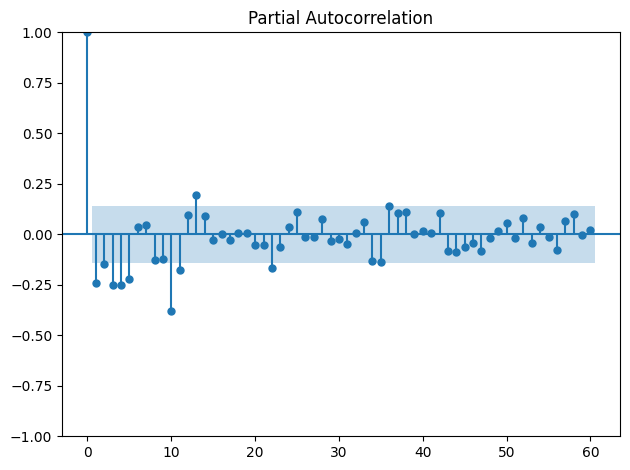

In [16]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(mumbai_diff, lags=60)


plt.tight_layout()

plt.savefig('figures/pacf.png', dpi=300)

I'm not really sure how to interprete the partial autocorellation in the context of a seasonal time series.so I'm using the SARIMA model to analyze

# Chosing the best parameters for SARIMA(p,d,q)(P,D,Q)m model

We already know that d = 1, and m = 12 (since the nb of observations per cycle is one per month). Also, D is = 0 since we didn't need to apply seasonal diferenciation.

Now we need to determine the rest of the parameters. By listing the values of p, q, P and Q, trying multiple combinations of parameters and chosing the one that gives the best results when we forcast it.



In [17]:
def optimize_SARIMA(train, order_list, d, D, s) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                train,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
        nParams=sum(order)
        aic = model.aic
        results.append([nParams, order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['# of Params','(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = mumbai_diff[:-12]

d = 1
D = 0
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

<ipython-input-17-a3434d6ab23a>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

based on the results we get,